In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta, date
from ast import literal_eval
from matplotlib import pyplot as plt

# load transaction data
trans_df = pd.read_csv('../../../data/cabot_data/sprint_3/trans_s3_raw.csv',
                       parse_dates=['LOOK_DATE'])

# load predicted lambdas
results_df = pd.read_csv('sprint4_results.csv')

# load compatible types
compat_df = pd.read_csv('mu_matrix_indep.csv')

n_intraday = 81

In [ ]:
ba_diffs = pd.read_csv('../../../data/cabot_data/sprint_4/ba_diffs.csv', index_col='Unnamed: 0')

# process ba_diffs
ba_diffs['LOOK_WEEK'] = daily_count['LOOK_WEEK']/n_intraday
ba_diffs_weekly = ba_diffs.groupby(by='LOOK_WEEK').mean()

In [ ]:
# get binary value from purchases
trans_df['PURCHASE_COUNT'] = trans_df['PRODUCT'].astype(str) != 'nan'
trans_df['PURCHASE_COUNT'] = trans_df.apply(lambda row: 1 if row['PURCHASE_COUNT'] == True else 0, axis=1)

# get look weeks and look_dow
trans_df['LOOK_WEEK'] = trans_df.apply(lambda row: row['LOOK_DATE'].week, axis=1)
trans_df['LOOK_DOW'] = trans_df.apply(lambda row: row['LOOK_DATE'].dayofweek, axis=1)

# transform look day into numbers
trans_df['LOOK_DOY'] = trans_df.apply(lambda row: row['LOOK_DATE'].dayofyear - 1, axis=1)

# process predicted lambdas
num_days = 299
lamb_df = results_df.iloc[results_df.index > len(results_df) - (num_days + 1),:]
lamb_df = lamb_df.reset_index().drop(['index','var'], axis=1)
lamb_df['LOOK_DOY'] = lamb_df.index + 1
lamb_df = lamb_df.rename(index=str, columns={" value": "pred_lambda"})
lamb_df = lamb_df.set_index('LOOK_DOY')

In [ ]:
# merge predicted lambdas into main df
trans_df = trans_df.merge(lamb_df, on='LOOK_DOY')

# get daily counts and diff
daily_count = trans_df.groupby('LOOK_DOY').sum()
daily_count['diff'] = daily_count['PURCHASE_COUNT'] - daily_count['pred_lambda']

# get weekly counts and diff
weekly_count = trans_df.groupby('LOOK_WEEK').sum()
weekly_count['diff'] = weekly_count['PURCHASE_COUNT'] - weekly_count['pred_lambda']

# get dow counts and diff
dow_count = trans_df.groupby('LOOK_DOW').sum()
dow_count['diff'] = dow_count['PURCHASE_COUNT'] - dow_count['pred_lambda']


In [ ]:
# save figure for daily differences
plt.figure(figsize=(20,60))
plt.barh(daily_count.index, daily_count['diff'], align='center', alpha=0.5)
plt.yticks(daily_count.index)
plt.ylabel('Look_Day')
plt.xlabel('Count vs Predicted count difference')
plt.title('Look_day vs predicted count difference')
plt.savefig('daily_count_diff.png', format='png')
plt.show()

In [ ]:
# save figure for weekly differences
plt.figure(figsize=(20,20))
plt.barh(weekly_count.index, weekly_count['diff'], align='center', alpha=0.5, color='g')
plt.yticks(weekly_count.index)
plt.ylabel('Look_week')
plt.xlabel('Count vs Predicted count difference')
plt.title('Look_week vs predicted count difference')
plt.savefig('weekly_count_diff.png', format='png')
plt.show()

In [ ]:
# save figure for dow differences
plt.figure(figsize=(20,10))
plt.barh(dow_count.index, dow_count['diff'], align='center', alpha=0.5, color='r')
plt.yticks(dow_count.index)
plt.ylabel('Look_dow')
plt.xlabel('Count vs Predicted count difference')
plt.title('Look_dow vs predicted count difference')
plt.savefig('dow_count_diff.png', format='png')
plt.show()

In [ ]:
# daily counts
plt.figure(figsize=(20,60))
plt.barh(daily_count.index, daily_count['PURCHASE_COUNT'], align='center', alpha=0.5, color='b')
plt.yticks(daily_count.index)
plt.ylabel('Look_day')
plt.xlabel('Count')
plt.title('Daily Counts')
# plt.savefig('weekly_counts.png', format='png')
plt.show()

In [ ]:
# daily lambdas
plt.figure(figsize=(20,60))
plt.barh(daily_count.index, daily_count['pred_lambda'], align='center', alpha=0.5, color='y')
plt.yticks(daily_count.index)
plt.ylabel('Lambda')
plt.xlabel('Count')
plt.title('Daily Lambdas')
# plt.savefig('weekly_counts.png', format='png')
plt.show()

In [ ]:
# save figure for weekly counts
plt.figure(figsize=(20,20))
plt.barh(weekly_count.index, weekly_count['PURCHASE_COUNT'], align='center', alpha=0.5, color='g')
plt.yticks(weekly_count.index)
plt.ylabel('Look_week')
plt.xlabel('Count')
plt.title('Weekly Counts')
plt.savefig('weekly_counts.png', format='png')
plt.show()

In [ ]:
# weekly lambdas
plt.figure(figsize=(20,20))
plt.barh(weekly_count.index, weekly_count['pred_lambda'], align='center', alpha=0.5, color='b')
plt.yticks(weekly_count.index)
plt.ylabel('Lambda')
plt.xlabel('Count')
plt.title('Weekly Lambdas')
# plt.savefig('weekly_counts.png', format='png')
plt.show()

In [ ]:
# daily ba_diffs
plt.figure(figsize=(20,20))
plt.barh(ba_diffs.index, ba_diffs['BA_DIFF'], align='center', alpha=0.5, color='b')
plt.yticks(weekly_count.index)
plt.ylabel('BA_DIFF')
plt.xlabel('Count')
plt.title('Daily ba_diff')
# plt.savefig('weekly_counts.png', format='png')
plt.show()

In [ ]:
# weekly ba_diffs
plt.figure(figsize=(20,20))
plt.barh(ba_diffs_weekly.index, ba_diffs_weekly['BA_DIFF'], align='center', alpha=0.5, color='g')
plt.yticks(weekly_count.index)
plt.ylabel('BA_DIFF')
plt.xlabel('Count')
plt.title('Weekly ba_diff')
# plt.savefig('weekly_counts.png', format='png')
plt.show()

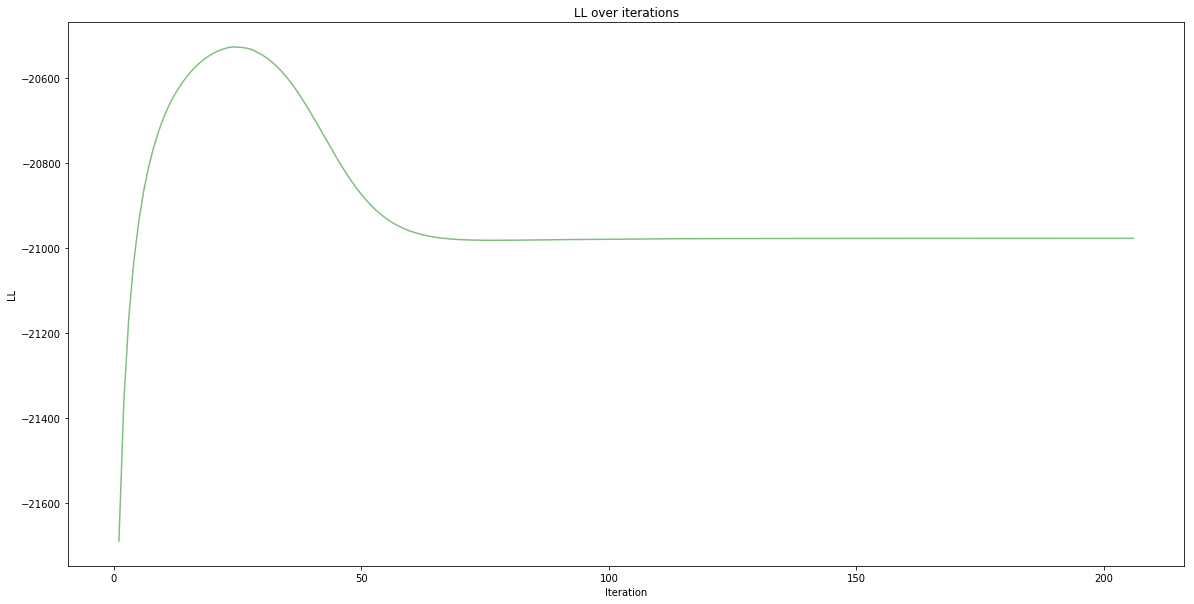

In [275]:
#LL convergence graph
lls = pd.read_csv('lls_toy.csv')
lls = lls.iloc[1:,:]

plt.figure(figsize=(20,10))
plt.plot(lls.index, lls['LL'], alpha=0.5, color='g')
# plt.xticks(weekly_count.index)
plt.ylabel('LL')
plt.xlabel('Iteration')
plt.title('LL over iterations')
# plt.savefig('weekly_counts.png', format='png')
plt.show()

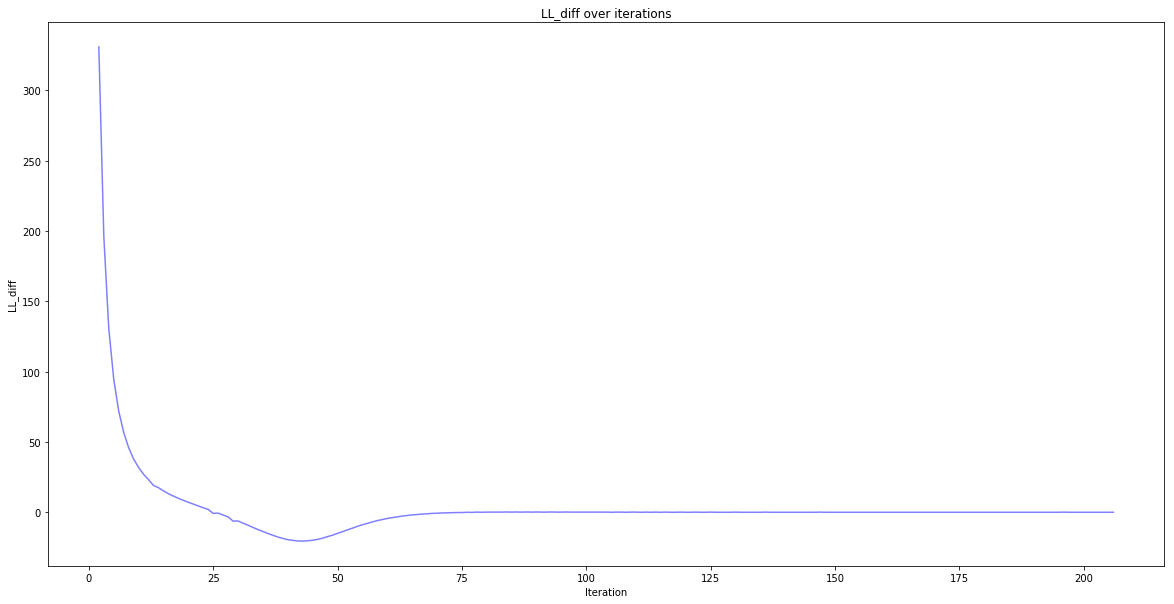

In [279]:
#LL diffs graph
ll_diffs = lls['LL'] - lls['LL'].shift(+1)

plt.figure(figsize=(20,10))
plt.plot(lls.index, ll_diffs, alpha=0.5, color='b')
# plt.xticks(weekly_count.index)
plt.ylabel('LL_diff')
plt.xlabel('Iteration')
plt.title('LL_diff over iterations')
# plt.savefig('weekly_counts.png', format='png')
plt.show()

In [ ]:
# ## old code for getting lambda * xi as a residual

# # multiply xi by compatible types

# # create index for each day
# days_rep = np.arange(1, num_days + 1)
# days_rep = np.repeat(days_rep, num_intraday)
# compat_df['day'] = days_rep
# compat_df = compat_df.drop(['idx'], axis=1).set_index('day')

# # get type probs
# probs_df = results_df.iloc[results_df.index < compat_df.shape[1],:]
# probs_df.index = probs_df.index + 1
# probs_df = probs_df.drop(['var'], axis=1)
# probs_df = probs_df.rename(index=str, columns={" value": "value"})

# # multiply type probs by compatible types
# compat_df = compat_df.mul(probs_df['value'])


# # sum in each time period
# compat_df['sum_xi'] = compat_df.sum(axis=1)
# compat_df = compat_df[['sum_xi']]

# # multiply each x_i aggregate by lambda
# sum_lamb_xi_vec = []
# for index, row in compat_df.iterrows():
#     pred_lambda = lamb_df.loc[index, 'pred_lambda']
#     sum_lambda_xi = row['sum_xi'] * pred_lambda
#     sum_lamb_xi_vec.append(sum_lambda_xi)
    
# compat_df['sum_lamb_xi'] = sum_lamb_xi_vec